# PatientInsights : Advancing Patient Care through Enhanced Digital Record Analytics

## BA820 Final Project

#### Group 14 - Jishnu Moorty , Shivakumar Vinod Pillai , Yashvardhan Singh Ranawat

## Project Overview

### Problem Statement 
An estimated 80% of healthcare data is unstructured. The most common sources being clinical notes containing discharge summaries, lab reports , progress notes etc. Translating this data in a structured manner poses a unique challenge due to its inconsistent nature. The same concept can be articulated in numerous ways across different organizations and fields of specialty. Having a complete picture of this information at hand can lead to better care for patients and NLP combined with unsupervised learning can unlock the valuable insights trapped in unstructured data.


### Dataset & Data Source 
Medical Information Mart for Intensive Care (MIMIC-III) Clinical Database. Please find the [link](https://mimic.mit.edu/docs/iii/) here.

### Business Relevance 
- Risk Assessment: Streamlining manual workflows by identifying clinical concepts that indicate complicated conditions, to accurately characterize a patient’s risk 
- Quality Reporting : Converting unstructured data to provide a more accurate picture of a patient's health status while identifying gaps in care or documentation recorded. .
- Clinical Decision Support: Clustering can assist in helping providers make informed decisions through comparing similar cases and their outcomes. 
- Research and Knowledge Discovery: Researchers can uncover new associations and risk factors by analyzing clusters of patients with similar characteristics.


### Data Dictionary 

### Importing All Libraries

In [12]:
import re
from nltk.corpus import  stopwords
import spacy
import nltk
nltk.download('stopwords')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Connecting to BigQuery

In [13]:
from google.cloud import bigquery

client = bigquery.Client()

### Loading Data

This dataset was accesible through bigquery, Since only one member was provided access to use this data, we moved the tables to our own project's dataset. Original dataset is called 'physionet-data' on bigquery

### Note events Table 

##### Notes associated with hospital stays.

| Column      | Type      | Definition                                                                                   |
|-------------|-----------|----------------------------------------------------------------------------------------------|
| row_id      | int4      | Unique row identifier.                                                                       |
| subject_id  | int4      | Foreign key. Identifies the patient.                                                         |
| hadm_id     | int4      | Foreign key. Identifies the hospital stay.                                                   |
| chartdate   | timestamp | Date when the note was charted.                                                              |
| charttime   | timestamp | Date and time when the note was charted. Notes without a time have NULL in this column.      |
| storetime   | timestamp |                                                                                              |
| category    | varchar   | Category of the note, e.g., Discharge summary.                                               |
| description | varchar   | A more detailed categorization for the note, sometimes entered by free-text.                 |
| cgid        | int4      | Foreign key. Identifies the caregiver.                                                       |
| iserror     | bpchar    | Flag to highlight an error with the note.                                                    |
| text        | text      | Content of the note.                                                                         |



In [14]:
noteevents_query = ('''SELECT *  FROM `ba820-unsup-ml.mimic3.noteevents`''')

noteevents_data = client.query(noteevents_query).to_dataframe()

noteevents_data.head(2)

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,626262,63509,166932,2121-02-26,2121-02-26 15:13:00,2121-02-26 15:13:07,Nutrition,Clinical Nutrition Note,20157,<NA>,Subjective\n Reports does not have any appet...
1,640080,94661,126165,2177-11-13,2177-11-13 10:51:00,2177-11-13 10:51:54,Nutrition,Clinical Nutrition Note,17709,<NA>,Pt asleep.\n Pertinent medications: Flagyl s...


### Patients Data

##### Patients associated with an admission to the ICU.

| Column      | Type       | Definition                                                                                   |
|-------------|------------|----------------------------------------------------------------------------------------------|
| row_id      | int4       | Unique row identifier.                                                                       |
| subject_id  | int4       | Primary key. Identifies the patient.                                                         |
| gender      | varchar    | Gender.                                                                                      |
| dob         | timestamp  | Date of birth.                                                                               |
| dod         | timestamp  | Date of death. Null if the patient was alive at least 90 days post hospital discharge.       |
| dod_hosp    | timestamp  | Date of death recorded in the hospital records.                                              |
| dod_ssn     | timestamp  | Date of death recorded in the social security records.                                       |
| expire_flag | int4       | Flag indicating that the patient has died.                                                   |

In [15]:
patient_query = ('''SELECT *
                FROM `ba820-unsup-ml.mimic3.patients`''')

patient_data = client.query(patient_query).to_dataframe()

patient_data.head(2)

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,46038,98139,F,2035-02-19,2116-05-24,2116-05-24,2116-05-24,1
1,156,166,F,1805-01-23,2105-01-24,2105-01-24,2105-01-24,1


### Admissions Data

##### Hospital admissions associated with an ICU stay.

| Column               | Type      | Definition                                                                                   |
|----------------------|-----------|----------------------------------------------------------------------------------------------|
| row_id               | int4      | Unique row identifier.                                                                       |
| subject_id           | int4      | Foreign key. Identifies the patient.                                                         |
| hadm_id              | int4      | Primary key. Identifies the hospital stay.                                                   |
| admittime            | timestamp | Time of admission to the hospital.                                                           |
| dischtime            | timestamp | Time of discharge from the hospital.                                                         |
| deathtime            | timestamp | Time of death.                                                                               |
| admission_type       | varchar   | Type of admission, for example emergency or elective.                                        |
| admission_location   | varchar   | Admission location.                                                                          |
| discharge_location   | varchar   | Discharge location                                                                           |
| insurance            | varchar   | Insurance type.                                                                              |
| language             | varchar   | Language.                                                                                    |
| religion             | varchar   | Religion.                                                                                    |
| marital_status       | varchar   | Marital status.                                                                              |
| ethnicity            | varchar   | Ethnicity.                                                                                   |
| edregtime            | timestamp |                                                                                              |
| edouttime            | timestamp |                                                                                              |
| diagnosis            | varchar   | Diagnosis.                                                                                   |
| hospital_expire_flag | int2      |                                                                                              |
| has_chartevents_data | int2      | Hospital admission has at least one observation in the CHARTEVENTS table.                    |


In [16]:
admissions_query = ('''SELECT *
                FROM `ba820-unsup-ml.mimic3.admissions`''')

admissions_data = client.query(admissions_query).to_dataframe()

admissions_data.head(2)

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,40230,41420,143206,2147-01-06 16:57:00,2147-01-08 18:30:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,ICF,Medicare,ENGL,JEWISH,WIDOWED,WHITE,2147-01-06 13:30:00,2147-01-06 17:36:00,ACUTE SUBDURAL HEMATOMA,0,1
1,45890,58899,177890,2102-04-04 08:12:00,2102-04-10 16:00:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,ICF,Medicare,ENGL,NOT SPECIFIED,SINGLE,WHITE,2102-04-04 06:46:00,2102-04-04 08:33:00,THREATENED LEFT LOWER EXTREMITY,0,1


### EDA

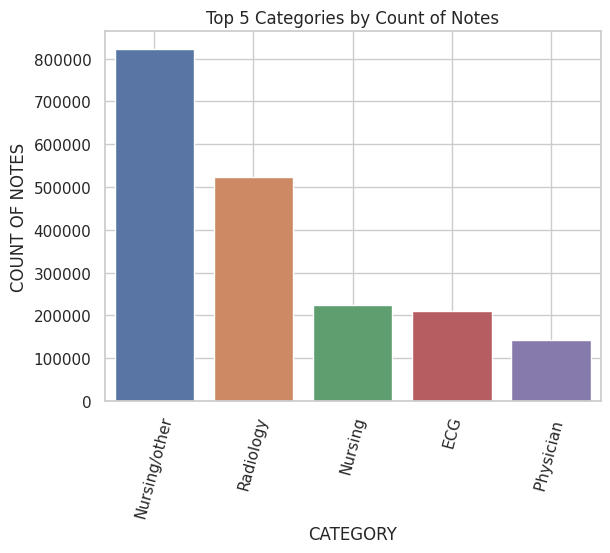

In [17]:
# Creating a countplot for Notes by Category
category_counts = noteevents_data['CATEGORY'].value_counts().sort_values(ascending=False)

top_5_categories = category_counts.head(5)
sns.countplot(data=noteevents_data, x='CATEGORY', order=top_5_categories.index)

plt.xlabel('CATEGORY')
plt.ylabel('COUNT OF NOTES')
plt.title('Top 5 Categories by Count of Notes')
plt.xticks(rotation=75)
plt.grid(True)
plt.show()

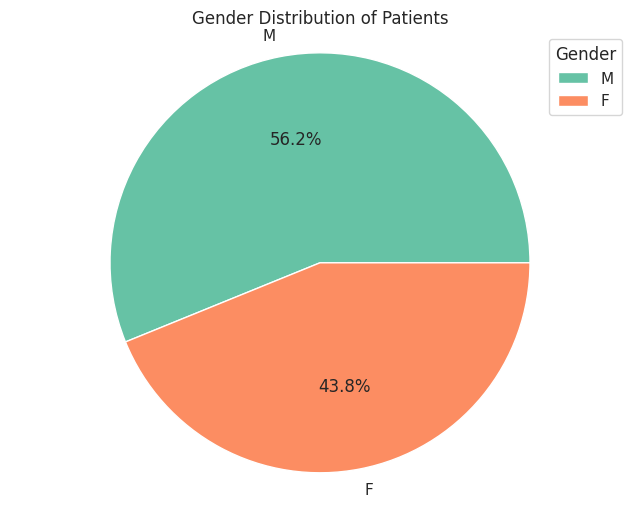

In [18]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(data=patient_data, x='GENDER', palette='Set2')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')


plt.clf()  
gender_counts = patient_data['GENDER'].value_counts()
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('Gender Distribution of Patients')
plt.axis('equal')  
plt.legend(title='Gender', loc='upper right')
plt.show()

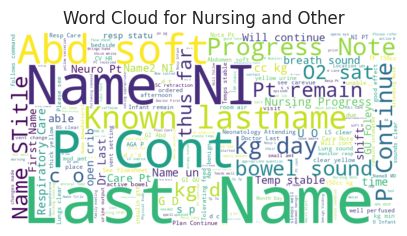

In [19]:
#Creating Word Cloud to understand the data
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all text from the 'TEXT' column into a single string
notes_corpus = ' '.join(noteevents_data[noteevents_data['CATEGORY']=='Nursing/other']['TEXT'])

# Generate a word cloud from the concatenated text
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(notes_corpus)

# Plot the word cloud
plt.figure(figsize=(5, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Nursing and Other')
plt.axis('off')
plt.show()

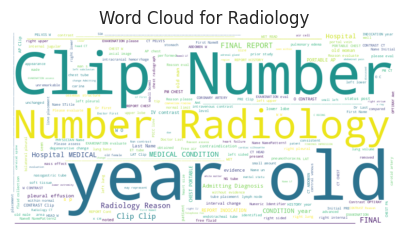

In [22]:
#Creating Word Cloud to understand the data
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all text from the 'TEXT' column into a single string
notes_corpus = ' '.join(noteevents_data[noteevents_data['CATEGORY']=='Radiology']['TEXT'])


wordcloud = WordCloud(width=800, height=400, background_color='white').generate(notes_corpus)


plt.figure(figsize=(5, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Radiology')
plt.axis('off')
plt.show()

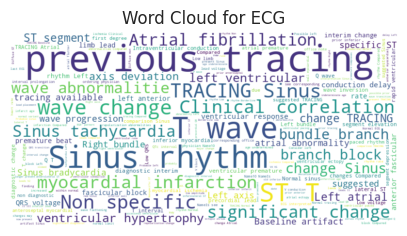

In [23]:
#Creating Word Cloud to understand the data
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all text from the 'TEXT' column into a single string
notes_corpus = ' '.join(noteevents_data[noteevents_data['CATEGORY']=='ECG']['TEXT'])


wordcloud = WordCloud(width=800, height=400, background_color='white').generate(notes_corpus)


plt.figure(figsize=(5, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for ECG')
plt.axis('off')
plt.show()

### Pre-processing Text Data - We had to sample due to resource and time constraints

##### Removing Punctuations

In [24]:
noteevents_query = ('''SELECT *  FROM `ba820-unsup-ml.mimic3.noteevents` TABLESAMPLE SYSTEM (5 PERCENT)''')

noteevents_data = client.query(noteevents_query).to_dataframe()

noteevents_data.head(2)

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,712715,72931,139565,2123-12-24,2123-12-24 14:56:00,2123-12-24 15:17:30,Physician,LP,19777,<NA>,TITLE:\n LP Note\n Patient draped and prep...
1,682141,58774,154395,2119-05-04,2119-05-04 18:00:00,2119-05-04 18:18:12,Physician,CVICU,15626,<NA>,CVICU\n HPI: 40M s/p emergent Replacement As...


In [25]:
def remove_punc(column):
    punc_pattern = r'[^\w\s]'
    column = re.sub(punc_pattern,"", column)
    return column
    

noteevents_data['text_cleaned'] = noteevents_data['TEXT'].apply(remove_punc)

noteevents_data[['TEXT','text_cleaned']].head(2)

,TEXT,text_cleaned
0,TITLE:\n LP Note\n Patient draped and prep...,TITLE\n LP Note\n Patient draped and prepp...
1,CVICU\n HPI: 40M s/p emergent Replacement As...,CVICU\n HPI 40M sp emergent Replacement Asce...


In [26]:
def remove_newlines(column):
    newline_pattern = r'\n'  
    return re.sub(newline_pattern, "", column)

noteevents_data['text_cleaned'] = noteevents_data['text_cleaned'].apply(remove_newlines)

noteevents_data[['TEXT','text_cleaned']].head(2)

,TEXT,text_cleaned
0,TITLE:\n LP Note\n Patient draped and prep...,TITLE LP Note Patient draped and prepped i...
1,CVICU\n HPI: 40M s/p emergent Replacement As...,CVICU HPI 40M sp emergent Replacement Ascend...


In [27]:
def remove_common_words(column):
    pattern = r'\b(?:First Name|Last Name|NamePattern1|firstname|lastname|name|TITLE)\b'
    return re.sub(pattern, "", column)

noteevents_data['text_cleaned'] = noteevents_data['text_cleaned'].apply(remove_common_words)

noteevents_data[['TEXT','text_cleaned']].head(2)

,TEXT,text_cleaned
0,TITLE:\n LP Note\n Patient draped and prep...,LP Note Patient draped and prepped in sta...
1,CVICU\n HPI: 40M s/p emergent Replacement As...,CVICU HPI 40M sp emergent Replacement Ascend...


In [31]:
def remove_abbreviation(column):
    # Pattern to match 'Dr.' optionally followed by a space
    pattern = r'\bDr\.\s?'
    return re.sub(pattern, "", column)


noteevents_data['text_cleaned'] = noteevents_data['text_cleaned'].apply(remove_abbreviation)

noteevents_data[['TEXT','text_cleaned']].head(2)

,TEXT,text_cleaned
0,TITLE:\n LP Note\n Patient draped and prep...,LP Note Patient draped prepped standard fashi...
1,CVICU\n HPI: 40M s/p emergent Replacement As...,CVICU HPI 40M sp emergent Replacement Ascendin...


In [32]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Ensure necessary NLTK downloads
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    cleaned_tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.lower() not in stop_words and word.isalpha()]
    
    return cleaned_tokens

noteevents_data['text_cleaned'] = noteevents_data['text_cleaned'].apply(preprocess_text)

noteevents_data[['TEXT','text_cleaned']].head(2)

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,TEXT,text_cleaned
0,TITLE:\n LP Note\n Patient draped and prep...,"[lp, note, patient, draped, prepped, standard,..."
1,CVICU\n HPI: 40M s/p emergent Replacement As...,"[cvicu, hpi, sp, emergent, replacement, ascend..."


In [34]:
from gensim.corpora import Dictionary


dictionary = Dictionary(noteevents_data['text_cleaned'])

# Convert document into the bag-of-words (BoW) format = list of (token_id, token_count) tuples
corpus = [dictionary.doc2bow(text) for text in noteevents_data['text_cleaned']]

In [36]:
!pip install gensim

In [ ]:
from gensim.models import LdaModel

# Number of topics
num_topics = 5

# Build LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     random_state=100,
                     update_every=0,
                     chunksize=100,
                     passes=5,
                     alpha='auto')

# Print the topics found by the model
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))

In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

# Prepare visualization for the LDA model
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)